In [1]:
import sys
sys.path.append("../src")
import tifffile
import torch
import numpy as np
from itertools import product
from pathlib import Path
from typing import Tuple, List
from skimage.util import view_as_windows
from semantic_bac_segment.pre_processing import ImageAdapter
from semantic_bac_segment.models.pytorch_altmodel import UNET
from semantic_bac_segment.segmentator import Segmentator, Segmentator2
from semantic_bac_segment.utils import normalize_percentile, get_device, empty_gpu_cache


In [6]:

img = tifffile.imread('../data/train/source_norm/img_1.tiff')


In [7]:

model_path = "../data/models/state_weights/unet_model_test_2_best_model.pth"
bac_seg_monai=Segmentator2(model_path, UNET(), patch_size=128, overlap_ratio=0.0, half_precision=True)


In [8]:
output=bac_seg_monai.predict(img)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x333c0a430>)

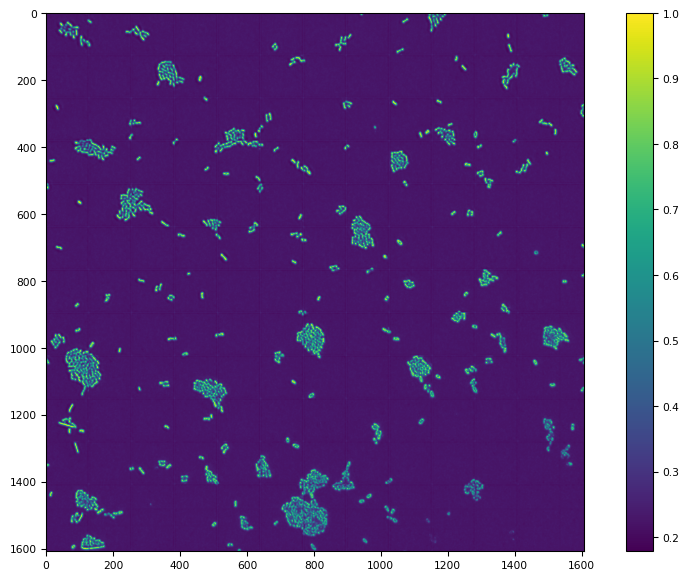

In [9]:
def sigmoid(z):
    """Sigmoid function for numpy arrays"""
    return 1 / (1 + np.exp(-z))
tifffile.imshow(np.power(sigmoid(output), 0.5))

In [50]:
model_path = "../data/models/state_weights/unet_model_test_2_best_model.pth"
bac_seg=Segmentator(model_path, UNET(), patch_size=128, overlap_ratio=0.0, half_precision=True)


In [51]:
output=bac_seg.predict(img)
tifffile.imshow(np.power(output, 0.5))